In [1]:
!pip install audformat
!pip install librosa
!pip install audiofile
!pip install Keras-Preprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.0/129.0 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 57.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.4/167.4 kB 23.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for iso-639: filename=iso_639-0.4.5-py3-none-any.whl size=168841 sha256=e80d9dc5e58112be4f0ec0b23e9507395fe12eed8105ceb4264d9823907f04d1
  Stored in directory: /root/.cache/pip/wheels/d8/78/cc/5478ca3b1c3f602eae6f8cdbd78f909c0a0bfa0bbcb5c7771f
Successfully built iso-639
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.0 MB/s eta 0:00:00


**Libraries loading**

In [2]:
import audformat
import audiofile
import librosa
import librosa.display

# Import the audio playback widget
import IPython.display as ipd
from IPython.display import Image

import matplotlib.pyplot as plt
from keras_preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
import keras
from keras import layers
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score,recall_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
import numpy as np

import math

**Downloading dataset**

In [3]:
!wget https://zenodo.org/record/7447302/files/emodb.zip

!unzip emodb.zip

--2023-11-19 08:32:03--  https://zenodo.org/record/7447302/files/emodb.zip
Resolving zenodo.org (zenodo.org)... 188.184.103.159, 188.184.98.238, 188.185.79.172, ...
Connecting to zenodo.org (zenodo.org)|188.184.103.159|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/7447302/files/emodb.zip [following]
--2023-11-19 08:32:04--  https://zenodo.org/records/7447302/files/emodb.zip
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 39981818 (38M) [application/octet-stream]
Saving to: ‘emodb.zip’

emodb.zip           100%[===================>]  38.13M  19.4MB/s    in 2.0s    

2023-11-19 08:32:07 (19.4 MB/s) - ‘emodb.zip’ saved [39981818/39981818]

Archive:  emodb.zip
   creating: emodb/
  inflating: emodb/db.emotion.categories.train.gold_standard.pkl  
   creating: emodb/wav/
  inflating: emodb/wav/14b01Fc.wav   
  inflating: emodb/wav/14a02Ea.wav   
  inflating: emodb/wav/15a02Ta.wav   
  

**Inializing constants**

In [4]:
# constants
sr = 16000
duration = 5
frame_length = 512
N_FRAMES = math.ceil(sr*duration/frame_length)
N_FEATURES = 180
N_EMOTIONS = 7
labels_encoded = {'anger':0, 'boredom':1, 'disgust':2, 'fear':3, 'happiness':4, 'sadness':5, 'neutral':5}
path = "emodb/"



In [5]:
keras.utils.set_random_seed(3)

**Loading dataset**

using the gold standard train and test data

In [6]:

db = audformat.Database.load('emodb')

df_test = db['emotion.categories.test.gold_standard'].get()

df_train = db['emotion.categories.train.gold_standard'].get()

print(f'samples in train: {df_train.shape[0]}, and test: {df_test.shape[0]}')

samples in train: 304, and test: 231


In [7]:
labels_encoded = {'anger':0, 'boredom':1, 'disgust':2, 'fear':3, 'happiness':4, 'sadness':5, 'neutral':6}
df_train['label']=df_train['emotion'].apply(lambda x:labels_encoded[x])
df_test['label']=df_test['emotion'].apply(lambda x:labels_encoded[x])

**Data Analysis**

In [8]:
for itm in list(df_test.index):
  s_rate = librosa.get_samplerate('emodb/'+itm)
  if s_rate != 16000:
    print(s_rate)

In [9]:
df_test.emotion.unique()

['happiness', 'boredom', 'neutral', 'anger', 'fear', 'disgust', 'sadness']
Categories (7, object): ['anger', 'boredom', 'disgust', 'fear', 'happiness', 'sadness', 'neutral']

In [10]:
data, sampling_rate = librosa.load('emodb/'+df_test.index[0])

In [11]:
len(data)

41093

In [12]:
data[0]

3.048674e-05

In [13]:
print(df_test.emotion[0])
ipd.Audio('emodb/'+df_test.index[0])


happiness


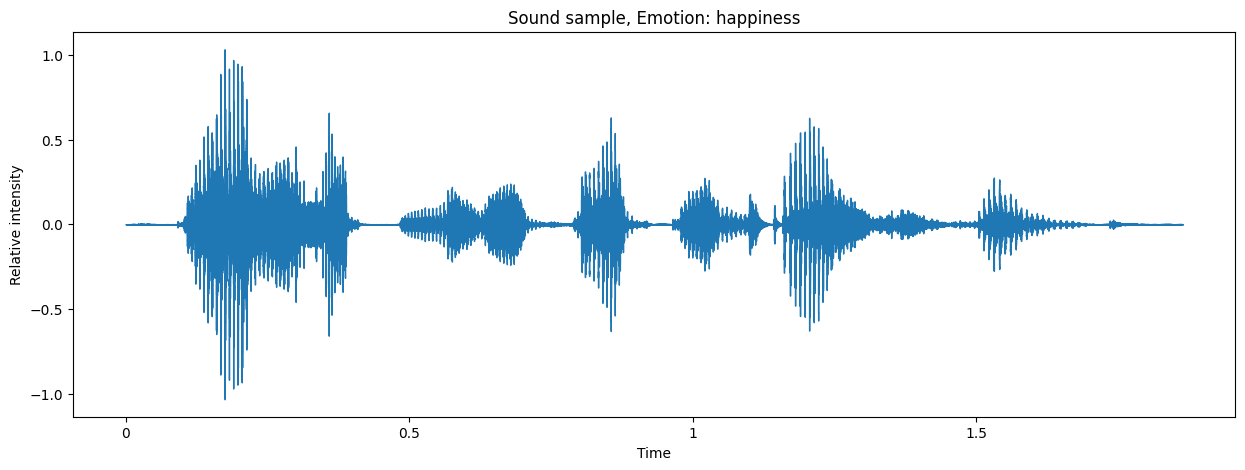

In [14]:
data, sampling_rate = librosa.load('emodb/'+df_test.index[0])
plt.figure(figsize=(15, 5))
plt.ylabel('Relative intensity')
plt.title('Sound sample, Emotion: '+df_test.emotion[0])
librosa.display.waveshow(data, sr=sampling_rate)

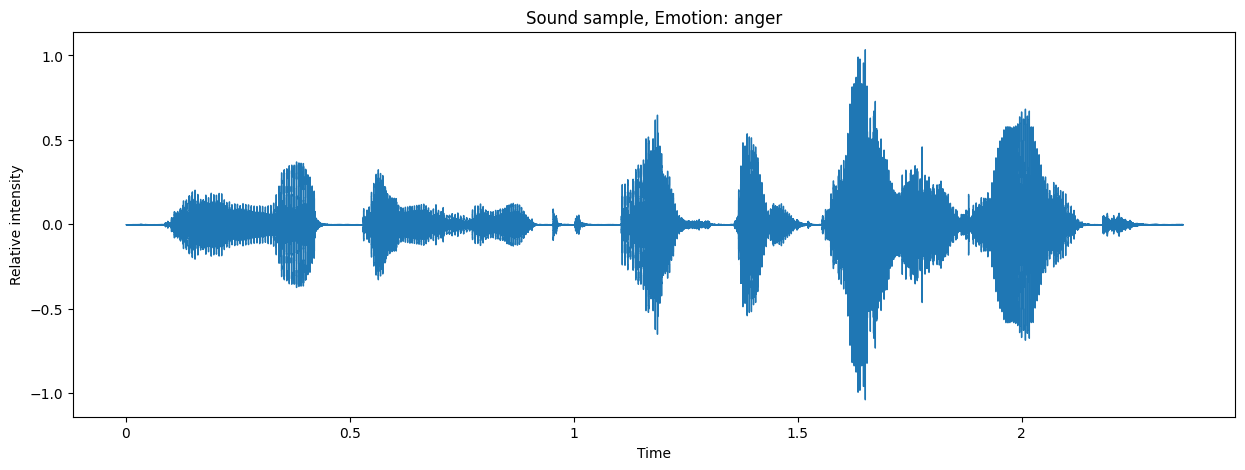

In [15]:
data, sampling_rate = librosa.load('emodb/'+df_test.index[3])
plt.figure(figsize=(15, 5))
plt.ylabel('Relative intensity')
plt.title('Sound sample, Emotion: '+df_test.emotion[3])
librosa.display.waveshow(data, sr=sampling_rate)

Text(0.5, 1.0, 'Train data histogram')

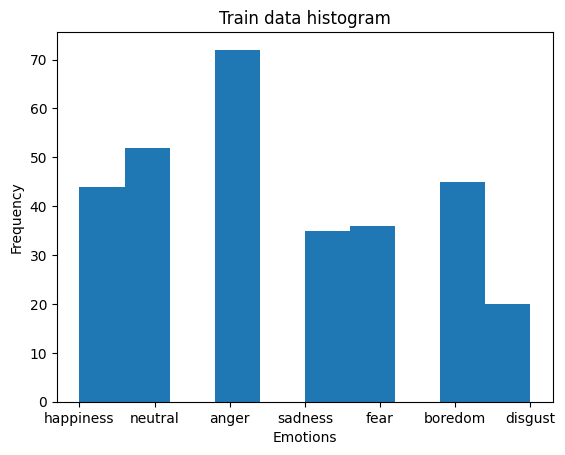

In [16]:
plt.hist(df_train['emotion'])
plt.xlabel('Emotions')
plt.ylabel('Frequency')
plt.title('Train data histogram')

Text(0.5, 1.0, 'Test data histogram')

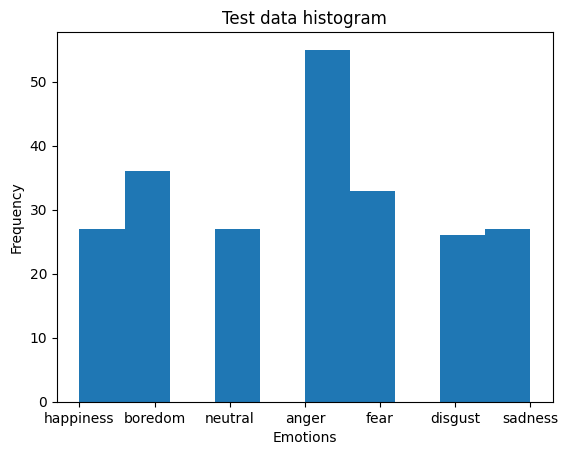

In [17]:
plt.hist(df_test['emotion'])
plt.xlabel('Emotions')
plt.ylabel('Frequency')
plt.title('Test data histogram')

In [18]:
data_mspect = librosa.feature.melspectrogram(y = data , sr = sr)

In [19]:
data_mspect.shape

(128, 102)

In [20]:
sampling_rate

22050

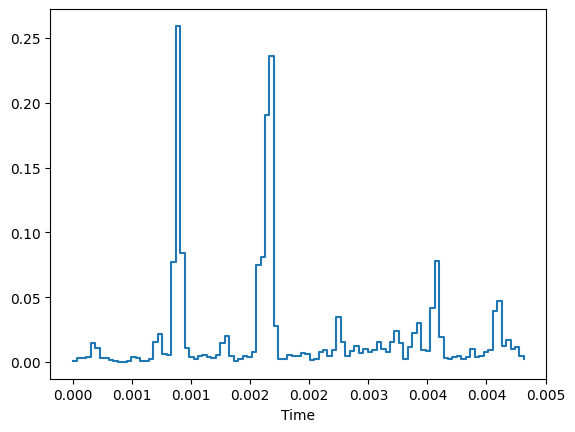

In [21]:
librosa.display.waveshow(data_mspect, sr=sampling_rate)

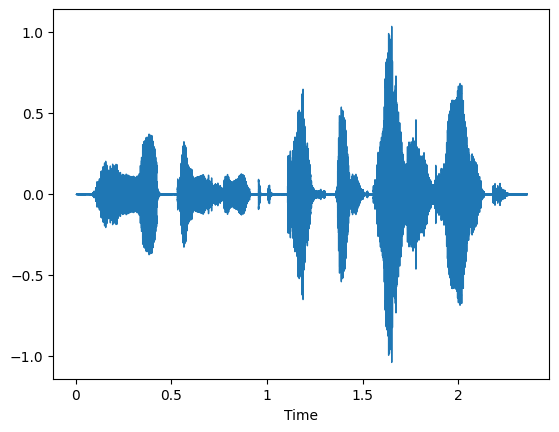

In [22]:
librosa.display.waveshow(data, sr=sampling_rate)

In [23]:
y, sampling_rate = librosa.load(path +  df_train.index[0], sr=sr, mono=True, duration=duration)

In [24]:
N_FRAMES

157

In [25]:
librosa.feature.spectral_centroid(y=y, sr=sr, hop_length=frame_length)[0].shape

(60,)

In [26]:
librosa.feature.spectral_contrast(y=y, sr=sr, hop_length=frame_length).shape

(7, 60)

In [27]:
librosa.feature.zero_crossing_rate(y=y,  hop_length=frame_length).shape

(1, 60)

In [28]:
librosa.feature.melspectrogram(y=y , sr = sampling_rate).shape

(128, 60)

In [29]:
N_FRAMES


157

In [30]:
N_FEATURES = 30

**Feature Extraction**

Extracting spectrogram features

In [31]:
def feature_extraction(df,feat_types):
    features = [] #(N_SAMPLES, N_FRAMES, N_FEATURES)
    emotions = df.label
    waves=[]
    for fnm in df.index:
      #y, sampling_rate = librosa.load(path +  fnm, sr=sr, mono=True, duration=duration)
      y, sampling_rate = librosa.load(path +  fnm, sr=sr, mono=True)
      waves.append(y)
    # pad to fixed length (zero, 'pre')
    waves_padded = pad_sequences(waves, maxlen=sr * duration, dtype="float32")
    for y in waves_padded:
      frames = []
      if 'centroid' in feat_types:
        spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr, hop_length=frame_length)[0] #https://librosa.org/doc/main/generated/librosa.feature.spectral_centroid.html
      if 'contrast' in feat_types:
        spectral_contrast_0 = librosa.feature.spectral_contrast(y=y, sr=sr, hop_length=frame_length)[0] #https://librosa.org/doc/main/generated/librosa.feature.spectral_contrast.html
        spectral_contrast_1 = librosa.feature.spectral_contrast(y=y, sr=sr, hop_length=frame_length)[1] #https://librosa.org/doc/main/generated/librosa.feature.spectral_contrast.html
        spectral_contrast_2 = librosa.feature.spectral_contrast(y=y, sr=sr, hop_length=frame_length)[2] #https://librosa.org/doc/main/generated/librosa.feature.spectral_contrast.html
        spectral_contrast_3 = librosa.feature.spectral_contrast(y=y, sr=sr, hop_length=frame_length)[3] #https://librosa.org/doc/main/generated/librosa.feature.spectral_contrast.html
        spectral_contrast_4 = librosa.feature.spectral_contrast(y=y, sr=sr, hop_length=frame_length)[4] #https://librosa.org/doc/main/generated/librosa.feature.spectral_contrast.html
        spectral_contrast_5 = librosa.feature.spectral_contrast(y=y, sr=sr, hop_length=frame_length)[5] #https://librosa.org/doc/main/generated/librosa.feature.spectral_contrast.html
        spectral_contrast_6 = librosa.feature.spectral_contrast(y=y, sr=sr, hop_length=frame_length)[6] #https://librosa.org/doc/main/generated/librosa.feature.spectral_contrast.html
      #print('spectral_centroid : ',spectral_centroid.shape)
      #print('spectral_contrast_0 : ',spectral_contrast_0.shape)
      if 'bandwidth' in feat_types:
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr, hop_length=frame_length)[0] #https://librosa.org/doc/main/generated/librosa.feature.spectral_bandwidth.html
      if 'spect_rolloff' in feat_types:
        spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, hop_length=frame_length)[0] #https://librosa.org/doc/main/generated/librosa.feature.spectral_rolloff.html
      if 'crossing_rate'  in feat_types:
        zero_crossing_rate = librosa.feature.zero_crossing_rate(y, hop_length=frame_length)[0] #https://librosa.org/doc/main/generated/librosa.feature.zero_crossing_rate.html
      #S, phase = librosa.magphase(librosa.stft(y=y, hop_length=frame_length))
      #rms = librosa.feature.rms(y=y, hop_length=frame_length, S=S)[0]
      if 'mfcc' in feat_types:
        mfcc = librosa.feature.mfcc(y=y, sr=sr, hop_length=frame_length)
        mfcc_der = librosa.feature.delta(mfcc)
      if 'melspect' in feat_types:
        feat_mspect = librosa.feature.melspectrogram(y=y , sr = sampling_rate)
      # print(feat_mspect.shape,mfcc.shape,N_FRAMES)
      # print('N_FRAMES : ', N_FRAMES)
      for i in range(N_FRAMES):
        f=[]
        if 'centroid' in feat_types:
          f.append(spectral_centroid[i])
        if 'contrast' in feat_types:
          f.append(spectral_contrast_0[i])
          # f.append(spectral_contrast_1[i])
          # f.append(spectral_contrast_2[i])
          # f.append(spectral_contrast_3[i])
          # f.append(spectral_contrast_4[i])
          # f.append(spectral_contrast_5[i])
          # f.append(spectral_contrast_6[i])
        if 'bandwidth' in feat_types:
          f.append(spectral_bandwidth[i])
        if 'spect_rolloff' in feat_types:
          f.append(spectral_rolloff[i])
        if 'crossing_rate'  in feat_types:
          f.append(zero_crossing_rate[i])
        #f.append(rms[i])

        if 'mfcc' in feat_types:
          for m_coeff in mfcc[:,i]:
           f.append(m_coeff)
          for m_coeff_der in mfcc_der[:, i]:
              f.append(m_coeff_der)
        if 'melspect' in feat_types:
          for m_spect in feat_mspect[:, i]:
            f.append(m_spect)
        frames.append(f)
        #print(len(f))

      features.append(frames)

    features = np.array(features)
    # flatten
    N_SAMPLES = len(features)
    print('bef : ', features.shape)

    features.shape = (N_SAMPLES, N_FRAMES * len(f) )
    print('aft : ', features.shape)

    emotions = np.array(emotions)
    return features,emotions,len(f)

In [101]:
all_features=['centroid', 'contrast', 'bandwidth', 'crossing_rate', 'mfcc', 'melspect' ]
feat_combs=[[feat] for feat in all_features]
feat_combs.append(all_features)
X_train,y_train,N_FEATURES=feature_extraction(df_train,feat_combs[1])
X_test,y_test,N_FEATURES=feature_extraction(df_test,feat_combs[1])
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# # balance train classes
sm = SMOTE()
X_train, y_train = sm.fit_resample(X_train, y_train)
# restore 3D shape
X_train.shape = (len(X_train), N_FRAMES, N_FEATURES)
X_test.shape = (len(X_test), N_FRAMES, N_FEATURES)

#Encoding the output classes into One hot encoding format
encoder = OneHotEncoder(sparse=False)
y_train= y_train.reshape(-1, 1)
# print(y_train.shape)
y_train = encoder.fit_transform(y_train)
# print(y_train.shape)
y_test= y_test.reshape(-1, 1)
# print(y_test.shape)
y_test = encoder.fit_transform(y_test)
# print(y_test.shape)

bef :  (304, 157, 1)
aft :  (304, 157)
bef :  (231, 157, 1)
aft :  (231, 157)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [102]:
print(X_train.shape)
print(y_train.shape)

(504, 157, 1)
(504, 7)


Applying Convolutional Neural Network model

In [43]:
def train_model(X_train,y_train,best_weights_file,batch_size):
  model = models.Sequential([
      layers.Reshape((X_train.shape[1],X_train.shape[2],1),input_shape=X_train.shape[1:]),
      layers.Conv2D(32,(4,4), activation='relu',input_shape=X_train.shape[1:]),
      layers.MaxPooling2D(pool_size=(3,3)),
      layers.Flatten(),
      layers.Dense(128, activation='relu'),
      layers.Dense(N_EMOTIONS, activation='softmax')  # Output layer with number of emotions
  ])
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  # print(str(model.summary()))

  # best_weights_file = "cnn_weights.h5"
  es = EarlyStopping(monitor='val_loss', mode='min',  patience=10)
  mc = ModelCheckpoint(best_weights_file, monitor='val_loss', mode='min',
                          save_best_only=True)
  model.fit(X_train, y_train, epochs=30, batch_size=batch_size, validation_split=0.2,callbacks=[es, mc])
  return model

In [44]:
# test acc and loss
def test_model(X_test,y_test,model,best_weights_file,batch_size):
  model.load_weights(best_weights_file) # load the best saved model
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy',keras.metrics.Recall()])
  test_metrics = model.evaluate(X_test, y_test, batch_size=batch_size)
  print("\n%s: %.2f%%" % ("test " + model.metrics_names[1], test_metrics[1] * 100))
  print("%s: %.2f" % ("test " + model.metrics_names[2], test_metrics[2]* 100))
  return test_metrics


In [45]:
all_features=['centroid', 'contrast', 'bandwidth', 'crossing_rate','spect_rolloff', 'mfcc', 'melspect' ]
feat_combs=[['mfcc'],['melspect']]
for feat in all_features:
  feat_combs.append(list((set(all_features)-set([feat]))))
feat_combs.append(all_features)
results={}
for feat_types in feat_combs:
  model_file_name=''.join(f+'_' for f in feat_types)
  print(model_file_name)
  X_train,y_train,N_FEATURES=feature_extraction(df_train,feat_types)
  X_test,y_test,N_FEATURES=feature_extraction(df_test,feat_types)
  scaler = StandardScaler()
  scaler.fit(X_train)
  X_train = scaler.transform(X_train)
  X_test = scaler.transform(X_test)

  # # balance train classes
  sm = SMOTE()
  X_train, y_train = sm.fit_resample(X_train, y_train)
  # restore 3D shape
  X_train.shape = (len(X_train), N_FRAMES, N_FEATURES)
  X_test.shape = (len(X_test), N_FRAMES, N_FEATURES)

  #Encoding the output classes into One hot encoding format
  encoder = OneHotEncoder(sparse=False)
  y_train= y_train.reshape(-1, 1)
  # print(y_train.shape)
  y_train = encoder.fit_transform(y_train)
  # print(y_train.shape)
  y_test= y_test.reshape(-1, 1)
  # print(y_test.shape)
  y_test = encoder.fit_transform(y_test)
  # print(y_test.shape)

  batch_size=32
  model=train_model(X_train,y_train,model_file_name,batch_size)

  test_metrics=test_model(X_test,y_test,model, model_file_name,batch_size)
  print (test_metrics)
  results[model_file_name]=test_metrics
print(results)

mfcc_
bef :  (304, 157, 40)
aft :  (304, 6280)
bef :  (231, 157, 40)
aft :  (231, 6280)
Epoch 1/30


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


13/13 [==============================] - 3s 199ms/step - loss: 3.1996 - accuracy: 0.2382 - val_loss: 1.5513 - val_accuracy: 0.4653
Epoch 2/30
13/13 [==============================] - 4s 355ms/step - loss: 1.4441 - accuracy: 0.5136 - val_loss: 1.4090 - val_accuracy: 0.4950
Epoch 3/30
13/13 [==============================] - 3s 204ms/step - loss: 0.9328 - accuracy: 0.7122 - val_loss: 1.0541 - val_accuracy: 0.6733
Epoch 4/30
13/13 [==============================] - 2s 181ms/step - loss: 0.6233 - accuracy: 0.7916 - val_loss: 0.6903 - val_accuracy: 0.7723
Epoch 5/30
13/13 [==============================] - 2s 181ms/step - loss: 0.4682 - accuracy: 0.8462 - val_loss: 0.5197 - val_accuracy: 0.8515
Epoch 6/30
13/13 [==============================] - 2s 178ms/step - loss: 0.3376 - accuracy: 0.9057 - val_loss: 0.4023 - val_accuracy: 0.8911
Epoch 7/30
13/13 [==============================] - 3s 211ms/step - loss: 0.2834 - accuracy: 0.9057 - val_loss: 0.3780 - val_accuracy: 0.9109
Epoch 8/30
13/13 

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/30
13/13 [==============================] - 9s 589ms/step - loss: 2.9344 - accuracy: 0.4342 - val_loss: 0.8117 - val_accuracy: 0.7228
Epoch 2/30
13/13 [==============================] - 8s 621ms/step - loss: 0.4552 - accuracy: 0.8834 - val_loss: 0.1901 - val_accuracy: 0.9802
Epoch 3/30
13/13 [==============================] - ETA: 0s - loss: 0.1124 - accuracy: 0.9752

13/13 [==============================] - 8s 589ms/step - loss: 0.1124 - accuracy: 0.9752 - val_loss: 0.0918 - val_accuracy: 1.0000
Epoch 4/30
13/13 [==============================] - 8s 649ms/step - loss: 0.0434 - accuracy: 0.9901 - val_loss: 0.0552 - val_accuracy: 1.0000
Epoch 5/30
13/13 [==============================] - 7s 521ms/step - loss: 0.0140 - accuracy: 1.0000 - val_loss: 0.0276 - val_accuracy: 1.0000
Epoch 6/30
13/13 [==============================] - 8s 654ms/step - loss: 0.0085 - accuracy: 1.0000 - val_loss: 0.0163 - val_accuracy: 1.0000
Epoch 7/30
13/13 [==============================] - 6s 495ms/step - loss: 0.0056 - accuracy: 1.0000 - val_loss: 0.0126 - val_accuracy: 1.0000
Epoch 8/30
13/13 [==============================] - 8s 661ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.0105 - val_accuracy: 1.0000
Epoch 9/30
13/13 [==============================] - 6s 494ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.0087 - val_accuracy: 1.0000
Epoch 10/30
13/13

bef :  (304, 157, 172)
aft :  (304, 27004)
bef :  (231, 157, 172)
aft :  (231, 27004)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/30
13/13 [==============================] - 10s 711ms/step - loss: 4.3333 - accuracy: 0.4293 - val_loss: 0.8835 - val_accuracy: 0.8515
Epoch 2/30
13/13 [==============================] - 10s 791ms/step - loss: 0.9554 - accuracy: 0.8511 - val_loss: 0.2085 - val_accuracy: 0.9604
Epoch 3/30
13/13 [==============================] - 10s 823ms/step - loss: 0.1932 - accuracy: 0.9479 - val_loss: 0.0697 - val_accuracy: 1.0000
Epoch 4/30
13/13 [==============================] - 8s 656ms/step - loss: 0.0475 - accuracy: 0.9826 - val_loss: 0.0566 - val_accuracy: 1.0000
Epoch 5/30
13/13 [==============================] - 10s 792ms/step - loss: 0.0142 - accuracy: 1.0000 - val_loss: 0.0164 - val_accuracy: 1.0000
Epoch 6/30
13/13 [==============================] - 10s 826ms/step - loss: 0.0079 - accuracy: 1.0000 - val_loss: 0.0115 - val_accuracy: 1.0000
Epoch 7/30
13/13 [==============================] - 9s 674ms/step - loss: 0.0047 - accuracy: 1.0000 - val_loss: 0.0112 - val_accuracy: 1.0000
E

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/30
13/13 [==============================] - 11s 825ms/step - loss: 5.5367 - accuracy: 0.3449 - val_loss: 1.5881 - val_accuracy: 0.5050
Epoch 2/30
13/13 [==============================] - ETA: 0s - loss: 0.7952 - accuracy: 0.7692

13/13 [==============================] - 9s 705ms/step - loss: 0.7952 - accuracy: 0.7692 - val_loss: 0.3582 - val_accuracy: 0.9010
Epoch 3/30
13/13 [==============================] - 10s 827ms/step - loss: 0.2245 - accuracy: 0.9479 - val_loss: 0.2473 - val_accuracy: 0.9208
Epoch 4/30
13/13 [==============================] - 10s 782ms/step - loss: 0.1052 - accuracy: 0.9777 - val_loss: 0.0919 - val_accuracy: 1.0000
Epoch 5/30
13/13 [==============================] - 8s 637ms/step - loss: 0.0615 - accuracy: 0.9975 - val_loss: 0.0540 - val_accuracy: 1.0000
Epoch 6/30
13/13 [==============================] - 10s 809ms/step - loss: 0.0182 - accuracy: 1.0000 - val_loss: 0.0450 - val_accuracy: 1.0000
Epoch 7/30
13/13 [==============================] - 10s 745ms/step - loss: 0.0120 - accuracy: 1.0000 - val_loss: 0.0276 - val_accuracy: 1.0000
Epoch 8/30
13/13 [==============================] - 9s 668ms/step - loss: 0.0079 - accuracy: 1.0000 - val_loss: 0.0220 - val_accuracy: 1.0000
Epoch 9/30
13

bef :  (304, 157, 172)
aft :  (304, 27004)
bef :  (231, 157, 172)
aft :  (231, 27004)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/30
13/13 [==============================] - 11s 796ms/step - loss: 6.3731 - accuracy: 0.3548 - val_loss: 2.0300 - val_accuracy: 0.4752
Epoch 2/30
13/13 [==============================] - 10s 775ms/step - loss: 1.0667 - accuracy: 0.7866 - val_loss: 0.3696 - val_accuracy: 0.9109
Epoch 3/30
13/13 [==============================] - 9s 705ms/step - loss: 0.3196 - accuracy: 0.9156 - val_loss: 0.3077 - val_accuracy: 0.9109
Epoch 4/30
13/13 [==============================] - 9s 690ms/step - loss: 0.0840 - accuracy: 0.9752 - val_loss: 0.1264 - val_accuracy: 0.9901
Epoch 5/30
13/13 [==============================] - 10s 770ms/step - loss: 0.0379 - accuracy: 1.0000 - val_loss: 0.0549 - val_accuracy: 1.0000
Epoch 6/30
13/13 [==============================] - 10s 798ms/step - loss: 0.0227 - accuracy: 1.0000 - val_loss: 0.0354 - val_accuracy: 1.0000
Epoch 7/30
13/13 [==============================] - 9s 663ms/step - loss: 0.0142 - accuracy: 1.0000 - val_loss: 0.0316 - val_accuracy: 1.0000
Ep

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/30
13/13 [==============================] - 10s 669ms/step - loss: 6.9578 - accuracy: 0.3573 - val_loss: 0.7497 - val_accuracy: 0.8119
Epoch 2/30
13/13 [==============================] - 10s 780ms/step - loss: 1.1865 - accuracy: 0.6948 - val_loss: 0.4546 - val_accuracy: 0.9010
Epoch 3/30
13/13 [==============================] - 10s 750ms/step - loss: 0.3366 - accuracy: 0.9156 - val_loss: 0.4305 - val_accuracy: 0.9010
Epoch 4/30
13/13 [==============================] - 9s 677ms/step - loss: 0.1188 - accuracy: 0.9727 - val_loss: 0.2484 - val_accuracy: 0.9307
Epoch 5/30
13/13 [==============================] - ETA: 0s - loss: 0.0468 - accuracy: 0.9950

13/13 [==============================] - 10s 762ms/step - loss: 0.0468 - accuracy: 0.9950 - val_loss: 0.0917 - val_accuracy: 1.0000
Epoch 6/30
13/13 [==============================] - 10s 769ms/step - loss: 0.0232 - accuracy: 1.0000 - val_loss: 0.0565 - val_accuracy: 1.0000
Epoch 7/30
13/13 [==============================] - 10s 780ms/step - loss: 0.0124 - accuracy: 1.0000 - val_loss: 0.0426 - val_accuracy: 1.0000
Epoch 8/30
13/13 [==============================] - 8s 652ms/step - loss: 0.0080 - accuracy: 1.0000 - val_loss: 0.0354 - val_accuracy: 1.0000
Epoch 9/30
13/13 [==============================] - 10s 776ms/step - loss: 0.0061 - accuracy: 1.0000 - val_loss: 0.0267 - val_accuracy: 1.0000
Epoch 10/30
13/13 [==============================] - 10s 763ms/step - loss: 0.0047 - accuracy: 1.0000 - val_loss: 0.0219 - val_accuracy: 1.0000
Epoch 11/30
13/13 [==============================] - 9s 709ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.0185 - val_accuracy: 1.0000
Epoch 12/3

bef :  (231, 157, 172)
aft :  (231, 27004)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/30
13/13 [==============================] - 10s 688ms/step - loss: 4.3024 - accuracy: 0.4094 - val_loss: 0.9754 - val_accuracy: 0.6733
Epoch 2/30
13/13 [==============================] - 10s 706ms/step - loss: 0.7049 - accuracy: 0.8412 - val_loss: 0.7342 - val_accuracy: 0.8020
Epoch 3/30
13/13 [==============================] - 10s 772ms/step - loss: 0.3132 - accuracy: 0.9429 - val_loss: 0.1621 - val_accuracy: 0.9802
Epoch 4/30
13/13 [==============================] - 10s 768ms/step - loss: 0.1687 - accuracy: 0.9702 - val_loss: 0.1253 - val_accuracy: 0.9901
Epoch 5/30
13/13 [==============================] - 8s 654ms/step - loss: 0.0333 - accuracy: 0.9950 - val_loss: 0.0423 - val_accuracy: 1.0000
Epoch 6/30
13/13 [==============================] - 10s 772ms/step - loss: 0.0107 - accuracy: 1.0000 - val_loss: 0.0304 - val_accuracy: 1.0000
Epoch 7/30
13/13 [==============================] - 10s 765ms/step - loss: 0.0069 - accuracy: 1.0000 - val_loss: 0.0227 - val_accuracy: 1.0000


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/30
13/13 [==============================] - 9s 587ms/step - loss: 2.4935 - accuracy: 0.4814 - val_loss: 0.4159 - val_accuracy: 0.8515
Epoch 2/30
13/13 [==============================] - 8s 648ms/step - loss: 0.3481 - accuracy: 0.8933 - val_loss: 0.3215 - val_accuracy: 0.8911
Epoch 3/30
13/13 [==============================] - 7s 528ms/step - loss: 0.0788 - accuracy: 0.9727 - val_loss: 0.0788 - val_accuracy: 1.0000
Epoch 4/30
13/13 [==============================] - 8s 627ms/step - loss: 0.0253 - accuracy: 1.0000 - val_loss: 0.0624 - val_accuracy: 1.0000
Epoch 5/30
13/13 [==============================] - 7s 542ms/step - loss: 0.0116 - accuracy: 1.0000 - val_loss: 0.0326 - val_accuracy: 1.0000
Epoch 6/30
13/13 [==============================] - 8s 624ms/step - loss: 0.0069 - accuracy: 1.0000 - val_loss: 0.0192 - val_accuracy: 1.0000
Epoch 7/30
13/13 [==============================] - 7s 574ms/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.0146 - val_accuracy: 1.0000
Epoch 

13/13 [==============================] - 8s 574ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.0121 - val_accuracy: 1.0000
Epoch 9/30
13/13 [==============================] - 8s 642ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.0103 - val_accuracy: 1.0000
Epoch 10/30
13/13 [==============================] - 7s 513ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.0086 - val_accuracy: 1.0000
Epoch 11/30
13/13 [==============================] - 8s 626ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0073 - val_accuracy: 1.0000
Epoch 12/30
13/13 [==============================] - 7s 542ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0066 - val_accuracy: 1.0000
Epoch 13/30
13/13 [==============================] - 8s 623ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0058 - val_accuracy: 1.0000
Epoch 14/30
13/13 [==============================] - 7s 546ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0052 - val_accuracy: 1.0000
Epoch 15/30


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


13/13 [==============================] - ETA: 0s - loss: 4.0410 - accuracy: 0.2481

13/13 [==============================] - 4s 255ms/step - loss: 4.0410 - accuracy: 0.2481 - val_loss: 1.9458 - val_accuracy: 0.3762
Epoch 2/30
13/13 [==============================] - 4s 297ms/step - loss: 1.3540 - accuracy: 0.5980 - val_loss: 1.5193 - val_accuracy: 0.4356
Epoch 3/30
13/13 [==============================] - 2s 197ms/step - loss: 0.7731 - accuracy: 0.7444 - val_loss: 0.8924 - val_accuracy: 0.6337
Epoch 4/30
13/13 [==============================] - 2s 197ms/step - loss: 0.4720 - accuracy: 0.8685 - val_loss: 0.4253 - val_accuracy: 0.9109
Epoch 5/30
13/13 [==============================] - 2s 193ms/step - loss: 0.3370 - accuracy: 0.9057 - val_loss: 0.3004 - val_accuracy: 0.9307
Epoch 6/30
13/13 [==============================] - 3s 217ms/step - loss: 0.2548 - accuracy: 0.9404 - val_loss: 0.2499 - val_accuracy: 0.9505
Epoch 7/30
13/13 [==============================] - 3s 271ms/step - loss: 0.1878 - accuracy: 0.9628 - val_loss: 0.1945 - val_accuracy: 0.9604
Epoch 8/30
13/13 

bef :  (231, 157, 173)
aft :  (231, 27161)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/30
13/13 [==============================] - 11s 735ms/step - loss: 8.4531 - accuracy: 0.3102 - val_loss: 1.4299 - val_accuracy: 0.7030
Epoch 2/30
13/13 [==============================] - 10s 790ms/step - loss: 0.9559 - accuracy: 0.7221 - val_loss: 0.6811 - val_accuracy: 0.8713
Epoch 3/30
13/13 [==============================] - 10s 786ms/step - loss: 0.4432 - accuracy: 0.9032 - val_loss: 0.3558 - val_accuracy: 0.9802
Epoch 4/30
13/13 [==============================] - 9s 662ms/step - loss: 0.2059 - accuracy: 0.9553 - val_loss: 0.2663 - val_accuracy: 0.9703
Epoch 5/30
13/13 [==============================] - 10s 755ms/step - loss: 0.0895 - accuracy: 0.9876 - val_loss: 0.1246 - val_accuracy: 1.0000
Epoch 6/30
13/13 [==============================] - 10s 765ms/step - loss: 0.0375 - accuracy: 1.0000 - val_loss: 0.0520 - val_accuracy: 1.0000
Epoch 7/30
13/13 [==============================] - 10s 767ms/step - loss: 0.0178 - accuracy: 1.0000 - val_loss: 0.0370 - val_accuracy: 1.0000


Also, using BiLSTM Attention model

In [66]:
def create_model(units=256):
    input = keras.Input(shape=(N_FRAMES, N_FEATURES))
    states, forward_h, _, backward_h, _ = layers.Bidirectional(
        layers.LSTM(units, return_sequences=True, return_state=True)
    )(input)
    last_state = layers.Concatenate()([forward_h, backward_h])
    hidden = layers.Dense(units, activation="tanh", use_bias=False,
                          kernel_initializer=keras.initializers.RandomNormal(mean=0., stddev=1.)
                          )(states)
    out = layers.Dense(1, activation='linear', use_bias=False,
                          kernel_initializer=keras.initializers.RandomNormal(mean=0., stddev=1.)
                          )(hidden)
    flat = layers.Flatten()(out)
    energy = layers.Lambda(lambda x:x/np.sqrt(units))(flat)
    normalize = layers.Softmax()
    normalize._init_set_name("alpha")
    alpha = normalize(energy)
    context_vector = layers.Dot(axes=1)([states, alpha])
    context_vector = layers.Concatenate()([context_vector, last_state])

    pred = layers.Dense(N_EMOTIONS, activation="softmax")(context_vector)
    model = keras.Model(inputs=[input], outputs=[pred])
    model._init_set_name('Attention_BLSTM')
    print(str(model.summary()))
    return model

In [58]:
model=create_model()

Model: "Attention_BLSTM"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 157, 158)]           0         []                            
                                                                                                  
 bidirectional (Bidirection  [(None, 157, 512),           849920    ['input_1[0][0]']             
 al)                          (None, 256),                                                        
                              (None, 256),                                                        
                              (None, 256),                                                        
                              (None, 256)]                                                        
                                                                                    

In [67]:
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

In [68]:
best_weights_file = "attention_bilstm_weights.h5"
es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=10)
mc = ModelCheckpoint(best_weights_file, monitor='val_loss', mode='min', verbose=2,
                         save_best_only=True)
model.fit(
        X_train, y_train,
        epochs=30,
        batch_size=8,
        validation_split=0.2,
        callbacks=[es, mc],
        verbose=2
    )

Epoch 1/30

Epoch 1: val_loss improved from inf to 0.09217, saving model to attention_bilstm_weights.h5
51/51 - 14s - loss: 0.2603 - accuracy: 0.9529 - val_loss: 0.0922 - val_accuracy: 0.9802 - 14s/epoch - 283ms/step
Epoch 2/30

Epoch 2: val_loss improved from 0.09217 to 0.03182, saving model to attention_bilstm_weights.h5
51/51 - 29s - loss: 0.3950 - accuracy: 0.9404 - val_loss: 0.0318 - val_accuracy: 1.0000 - 29s/epoch - 567ms/step
Epoch 3/30

Epoch 3: val_loss improved from 0.03182 to 0.01017, saving model to attention_bilstm_weights.h5
51/51 - 12s - loss: 0.0296 - accuracy: 0.9926 - val_loss: 0.0102 - val_accuracy: 1.0000 - 12s/epoch - 240ms/step
Epoch 4/30

Epoch 4: val_loss improved from 0.01017 to 0.00746, saving model to attention_bilstm_weights.h5
51/51 - 12s - loss: 0.0210 - accuracy: 0.9950 - val_loss: 0.0075 - val_accuracy: 1.0000 - 12s/epoch - 243ms/step
Epoch 5/30

Epoch 5: val_loss improved from 0.00746 to 0.00322, saving model to attention_bilstm_weights.h5
51/51 - 12s 

In [70]:
# test acc and loss
model.load_weights(best_weights_file) # load the best saved model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy',keras.metrics.Recall()])
test_metrics = model.evaluate(X_test, y_test, batch_size=8)
print("\n%s: %.2f%%" % ("test " + model.metrics_names[1], test_metrics[1] * 100))
print("%s: %.2f" % ("test " + model.metrics_names[2], test_metrics[2]* 100))

29/29 [==============================] - 2s 59ms/step - loss: 2.9960 - accuracy: 0.5801 - recall_9: 0.5758

test accuracy: 58.01%
test recall_9: 57.58
